# Conduct reversal tests on directional data in MagIC format using PmagPy

## Introduction

This notebook is a template for importing data and conducting reversal tests using PmagPy. You can use it on any MagIC contribution with dual polarity site data. The example that is given is on paleomagnetic directional data from the following study that is in the MagIC database (https://earthref.org/MagIC/19903):

> Ao, An, Dekkers, Li, Xiao, Zhao, Xand Qiang (2013). Pleistocene magnetochronology of the fauna and Paleolithic sites in the Nihewan Basin: Significance for environmental and hominin evolution in North China. Quaternary Geochronology 18:78-92. doi:10.1016/J.QUAGEO.2013.06.004.

### Change the MagIC contribution

You can change what study this notebook is applied to by changing the `magic_id` in the **Download data and unpack data** code cell below.

### Apply to your own `sites.txt` data

You can also substitute in your own MagIC format `sites.txt` file. To do this, skip the **Download data and unpack data** section and go to the **Import the sites table** section after running the **Import packages** code.

## Import packages

In [1]:
import pmagpy.ipmag as ipmag
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Download and unpack data

### Download MagIC contribution

We can first download the data from MagIC by providing the `magic_id`.
If the directory name that is given is not provided, it will be created.
In the example, the data are put into a folder within this directory that is named `reversal_test_data`.

In [7]:
doi = '10.1016/J.QUAGEO.2013.06.004'
result, magic_file_name = ipmag.download_magic_from_doi(doi)

19903/magic_contribution_19903.txt extracted to magic_contribution.txt 



### Unpack the MagIC file

MagIC contributions are made up of distinct tables that can be unpacked. In this case, we are going to do a reversal test on the site level data so we are particularly interested in unpacking the `sites.txt` table from the MagIC file.

In [8]:
ipmag.download_magic(infile='magic_contribution.txt')

working on:  'contribution\r'
1  records written to file  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\contribution.txt
  data put in  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\contribution.txt
working on:  'locations\r'
1  records written to file  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\locations.txt
  data put in  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\locations.txt
working on:  'sites\r'
214  records written to file  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\sites.txt
  data put in  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\sites.txt
working on:  'samples\r'
214  records written to file  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\samples.txt
  data put in  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\samples.txt
working on:  'specimens\r'
214  records written to file  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\specimens.txt
  data put in  C:\Users\cioni\My Drive\Oxford\Teaching\Field Tests\specime

True

### Import the sites table

We can now use pandas to import the sites table to a pandas dataframe using the function `pd.read_csv()`.

We need to point `pd.read_csv()` to the file which with the above steps has the location and name of `'reversal_test/sites.txt'`. This can be changed if the file is in a different place or has a different name. For example, if it is in the same directory as the notebook it can be: `'sites.txt'`

In [10]:
# change the sites_file path if you want to use a file in a different directory
sites_file = 'sites.txt'
sites = pd.read_csv(sites_file,sep='\t',header=1)
sites.head()

,age_high,age_low,age_unit,citations,dir_dec,dir_inc,dir_tilt_correction,geologic_classes,geologic_types,height,lat,lithologies,location,lon,method_codes,site,vgp_lat
0,0,3,Ma,10.1016/j.quageo.2013.06.004,353.6,46.3,100,Sedimentary,Sediment Layer,-0.0,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,0.0,76.399711
1,0,3,Ma,10.1016/j.quageo.2013.06.004,2.6,59.7,100,Sedimentary,Sediment Layer,-2.3,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,2.3,87.978299
2,0,3,Ma,10.1016/j.quageo.2013.06.004,347.7,60.6,100,Sedimentary,Sediment Layer,-3.3,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,3.3,80.596793
3,0,3,Ma,10.1016/j.quageo.2013.06.004,338.2,44.2,100,Sedimentary,Sediment Layer,-4.3,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,4.3,66.955595
4,0,3,Ma,10.1016/j.quageo.2013.06.004,348.6,33.6,100,Sedimentary,Sediment Layer,-5.0,40.15,Silty Clay,"Daodi Section, Nihewan Basin",114.658333,LP-DIR-T:DE-BFL,5.0,66.113052


### Filter by tilt correction

When there are data in both geographic coordinates (without correction for bedding tilt) and data in tilt corrected coordinates, they each get their own row with different values in the `dir_tilt_correction` column:

- 0: No tilt correction applied. The data are in the geographic coordinate system (i.e., as they are currently oriented in the field).
- 100: Full (100%) tilt correction applied. The data are in the paleohorizontal coordinate system, meaning they have been corrected for tilting to represent their original horizontal position. 

In the example dataset, only the tilt-corrected values are available. As a result, all the entries have a `dir_tilt_correction` of 100. 
For completeness, we will filter and make a `sites_geo` dataframe where `dir_tilt_correction` is 0 and 
a `sites_tc` dataframe where `dir_tilt_correction` is 100. For this example, `sites_geo` will be empty, but 
it will be populated for a MagIC contribution where there are data in those coordinates.

In [11]:
sites_geo = sites[sites['dir_tilt_correction'] == 0]
sites_tc = sites[sites['dir_tilt_correction'] == 100]

### Make declination/inclination lists

We can extract specific columns from the dataframe by using the nomenclature `dataframe_name['column_name']`. In this case, we want to conduct a reversal test on the data in the `sites_geo` dataframe and are interested in the directional data which are the declination column `dir_dec` and the inclination column `dir_inc`. So using the code `sites['dir_dec']` will give us all the declinations which we can assign to a variable `sites_dec`.

If you wanted to do the test on the `sites_tc` data, you would switch in `sites_tc` for `sites_geo` in the text below.

In [12]:
sites_dec = sites_tc['dir_dec']
sites_inc = sites_tc['dir_inc']

## Plot the directions

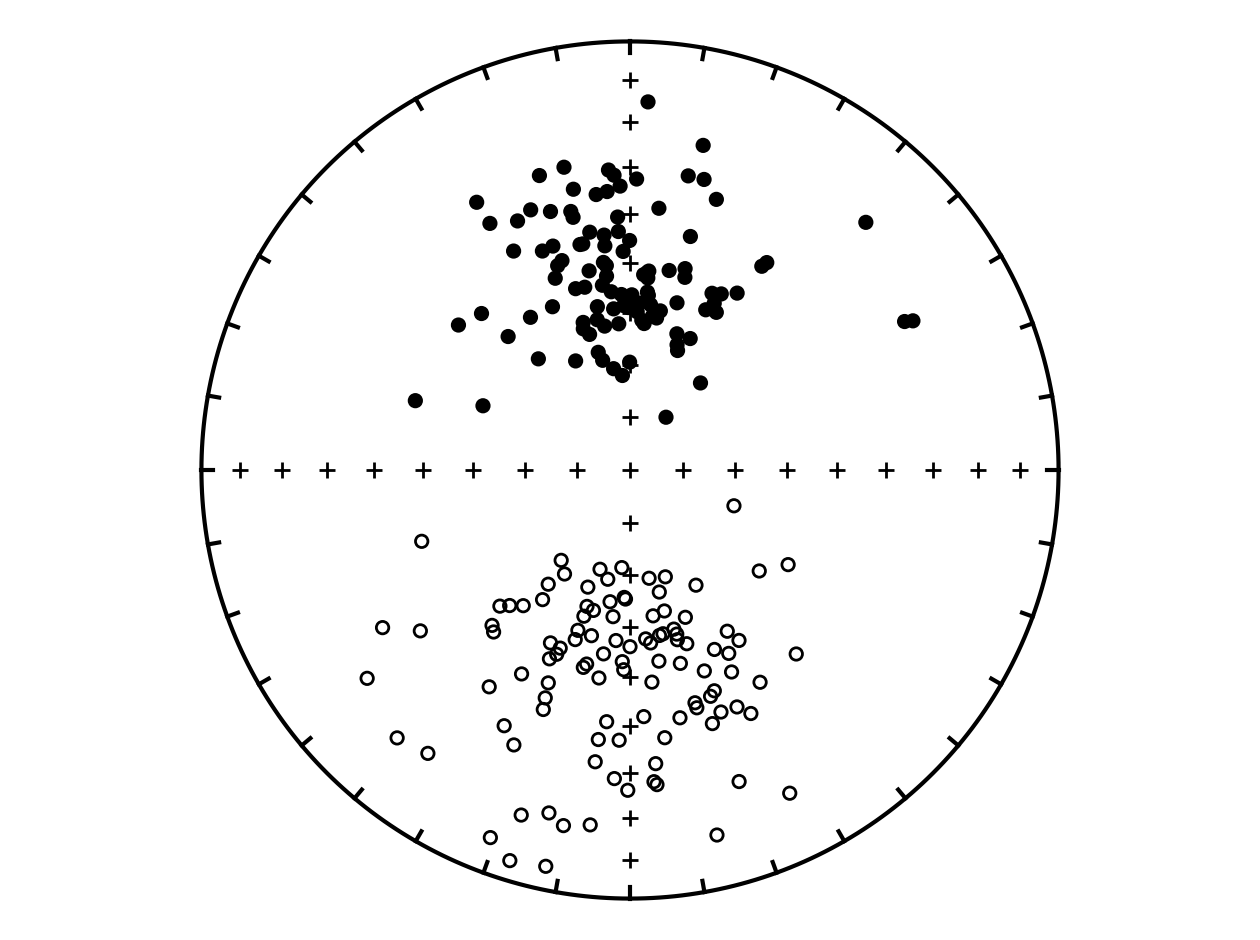

In [13]:
ipmag.plot_net()
ipmag.plot_di(sites_dec,sites_inc)

## Reversal tests

Now that we have extracted the declination and inclination values, let's conduct reversal tests on these data using the functions `ipmag.reversal_test_bootstrap` and `ipmag.reversal_test_MM1990`.

### Conduct the Watson common mean reversal test

We can do the Watson common mean test (together with McFadden and McElhinny (1990) classification) as well:

Results of Watson V test: 

Watson's V:           4.4
Critical value of V:  5.9
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 4.4
Critical angle for M&M1990:   5.0
The McFadden and McElhinny (1990) classification for
this test is: 'B'


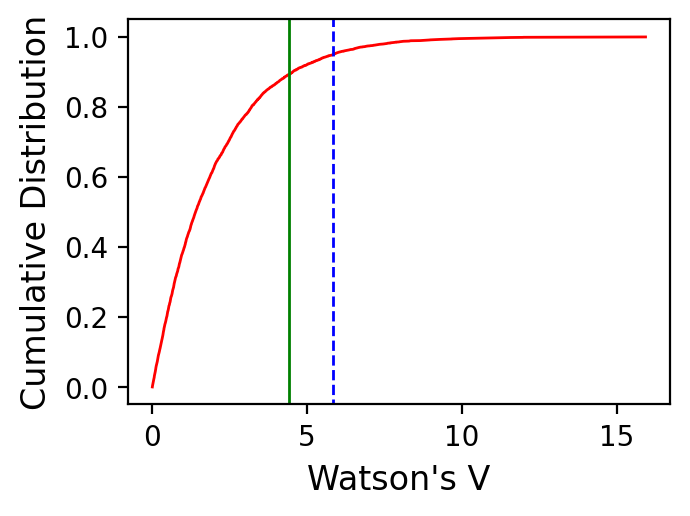

(1, 4.362992887306502, 5.022279977351931, 'B')

In [14]:
ipmag.reversal_test_MM1990(dec=sites_dec,
                           inc=sites_inc,
                           plot_CDF=True)

### Conduct the classic Tauxe et al. (1991) bootstrap reversal test

Let's go ahead and do the bootstrap reversal test using this `ipmag.reversal_test_bootstrap()` function.

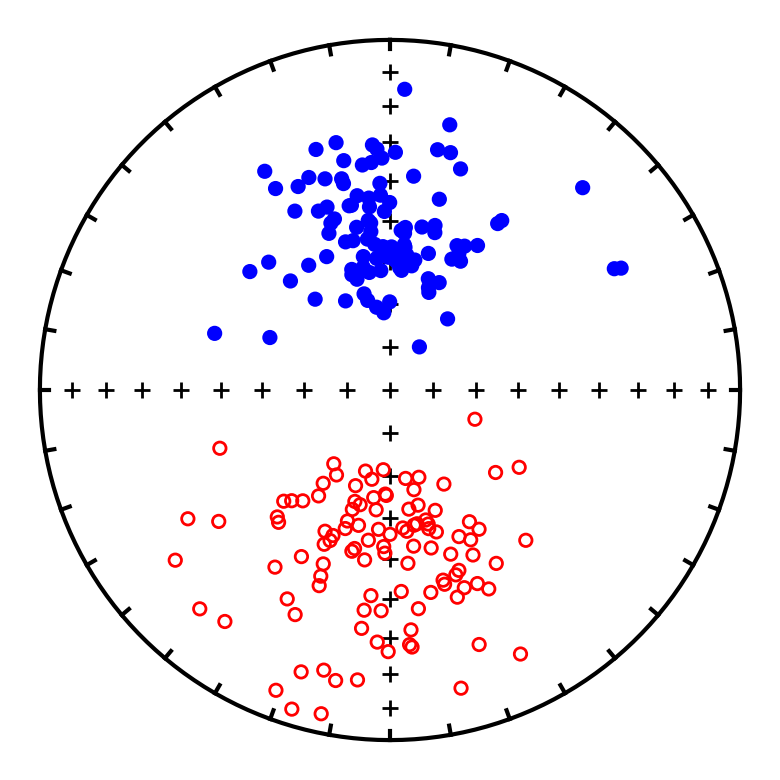

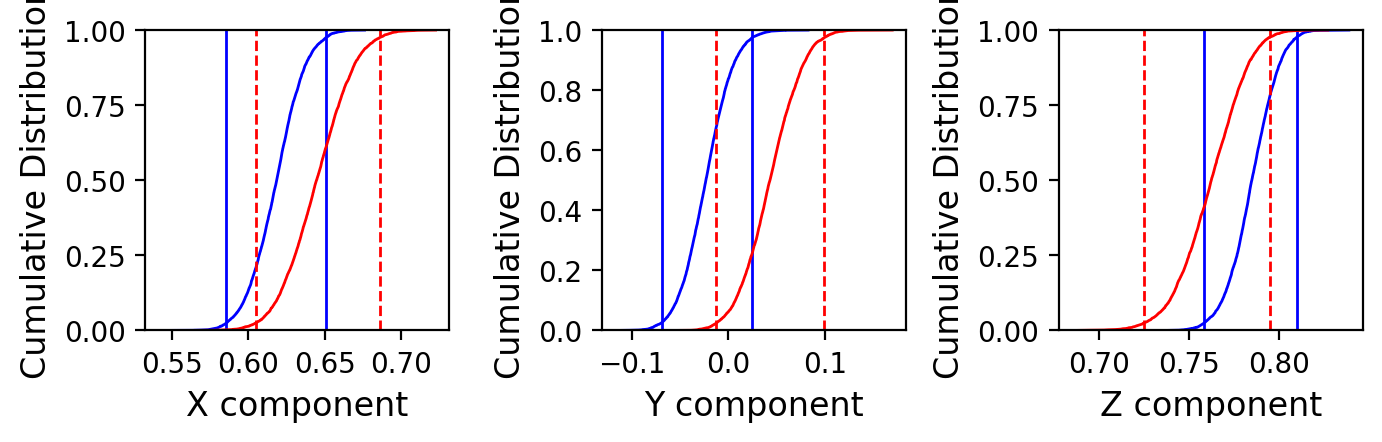

Pass


In [17]:
result = ipmag.reversal_test_bootstrap(dec=sites_dec,
                                       inc=sites_inc,
                                       plot_stereo = True)